In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pandas as pd

In [3]:
df = pd.read_csv('data\data_stunting_smote.csv')


In [4]:
df.head()

,Jenis Kelamin,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg),Stunting_Normal,Stunting_Severely Stunted,Stunting_Stunted,Stunting_Tall
0,0,0.791667,0.890909,0.759259,False,False,False,True
1,0,0.833333,0.638182,0.462963,False,False,True,False
2,0,0.416667,0.661818,0.574074,True,False,False,False
3,1,0.083333,0.140000,0.450617,False,True,False,False
4,1,0.208333,0.250909,0.611111,False,True,False,False


#### Splitting Data

In [9]:
x = df.drop(['Stunting_Normal', 'Stunting_Severely Stunted', 'Stunting_Tall', 'Stunting_Stunted' ], axis =1)
y = df[['Stunting_Normal', 'Stunting_Severely Stunted', 'Stunting_Tall', 'Stunting_Stunted']]

X_train_st, X_test_st, y_train_st, y_test_st = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y
)

print ("Jumlah data latih Stunting:", len(y_train_st))
print ("Jumlah data uji Stunting:", len(y_test_st))



Jumlah data latih Stunting: 214576
Jumlah data uji Stunting: 53644


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

model_stunting = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_st.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(4, activation='softmax')  # 4 output neuron untuk 4 kelas
])

model_stunting.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',  # loss untuk multi-class one-hot label
    metrics=['accuracy']
)

model_stunting.summary()


c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,156 (35.77 KB)

 Trainable params: 9,156 (35.77 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
from tensorflow.keras.callbacks import Callback
class StopAtAccuracy(Callback):
    def __init__(self, target=0.9):
        super(StopAtAccuracy, self).__init__()
        self.target = target

    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs.get('accuracy')  # ganti 'val_accuracy' kalau mau validasi
        if accuracy is not None:
            if accuracy >= self.target:
                print(f"\nAkurasi sudah mencapai {accuracy:.4f}, training dihentikan.")
                self.model.stop_training = True

# Pakai callback ini saat training:
stop_callback = StopAtAccuracy(target=0.95)

history_stunting = model_stunting.fit(
    X_train_st, y_train_st,
    epochs=50,
    validation_split=0.2,
    callbacks=[stop_callback]
)


Epoch 1/50
5365/5365 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step - accuracy: 0.9321 - loss: 0.1809 - val_accuracy: 0.9573 - val_loss: 0.1225
Epoch 2/50
5365/5365 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - accuracy: 0.9335 - loss: 0.1774 - val_accuracy: 0.9381 - val_loss: 0.1471
Epoch 3/50
5365/5365 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - accuracy: 0.9350 - loss: 0.1731 - val_accuracy: 0.9720 - val_loss: 0.0934
Epoch 4/50
5365/5365 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step - accuracy: 0.9363 - loss: 0.1698 - val_accuracy: 0.9599 - val_loss: 0.1120
Epoch 5/50
5365/5365 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - accuracy: 0.9393 - loss: 0.1646 - val_accuracy: 0.9556 - val_loss: 0.1159
Epoch 6/50
5365/5365 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - accuracy: 0.9392 - loss: 0.1637 - val_accuracy: 0.9610 - val_loss: 0.1026
Epoch 7/50
5365/5365 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - accuracy: 0.9397 - loss: 0.1607 - val_accuracy: 0.9689 - val_loss: 0.0949
Epoch 8/50
5365/5365 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - accuracy: 0.9392 - loss: 0

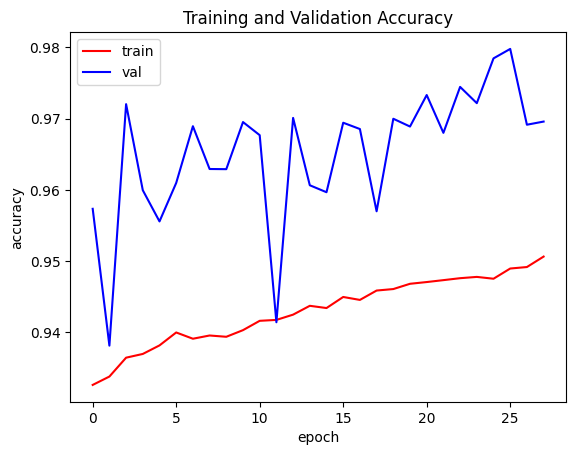

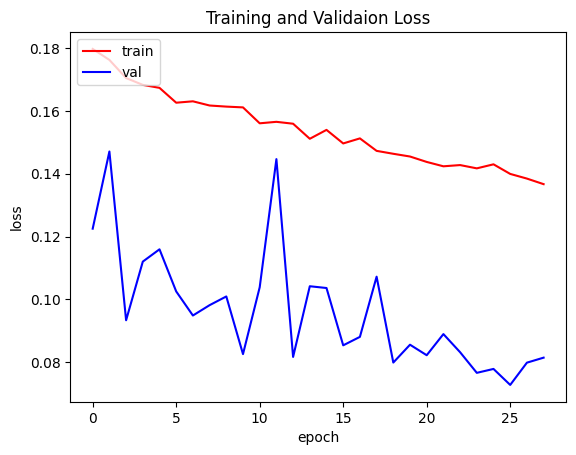

In [18]:
import matplotlib.pyplot as plt

acc = history_stunting.history['accuracy']
val_acc = history_stunting.history['val_accuracy']
loss = history_stunting.history['loss']
val_loss = history_stunting.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()